## 0. Load Library

In [1]:
import easydict

import json
import os
import pickle
import ast

import pandas as pd
import numpy as np

from varname import nameof

import matplotlib.pyplot as plt
import itertools
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## 1. Variable Declaration

In [3]:
args = easydict.EasyDict({
        "dataset_path" : "C:\\Users\\Bang\\JupyterProjects\\ComputerVision\\Skeleton\\dataset\\",
        "json_path" : "C:\\Users\\Bang\\JupyterProjects\\ComputerVision\\Skeleton\\dataset\\json\\",
        "split_list_path" : "C:\\Users\\Bang\\JupyterProjects\\ComputerVision\\Skeleton\\dataset\\split_list\\",
        "error_list_path" : "C:\\Users\\Bang\\JupyterProjects\\ComputerVision\\Skeleton\dataset\\error_list\\",
        "error_list_txt_path" : "C:\\Users\\Bang\\JupyterProjects\\ComputerVision\\Skeleton\dataset\\error_list\\error_list.txt",
        "saved_model_path" : "C:\\Users\\Bang\\JupyterProjects\\ComputerVision\\Skeleton\\saved_model\\",
        "keypoints_num" : 17,
        "keypoints_dimension" : ["x", "y"],
        "scaler": {"MinMaxScaler":MinMaxScaler(), "StandardScaler":StandardScaler(), "RobustScaler":RobustScaler(), "MaxAbsScaler":MaxAbsScaler()},
        "scaler_default": RobustScaler(),
        "y_list": {"neck":"neck", "trunk":"trunk", "upperarm":"upperarm", "lowerarm":"lowerarm", "legs":"legs", "json_trunk_twist":"json_trunk_twist"},
        "y_default":"neck",
        "classifier":{"KC":KNeighborsClassifier(n_neighbors = 5), "DTC":DecisionTreeClassifier(random_state=32), "RFC":RandomForestClassifier(random_state=32), "SVC":svm.SVC()},
        "classifier_default":KNeighborsClassifier(n_neighbors = 5),
        "best_classifier_name":"KC",
        "knn_neighbors_list" : range(1,51),
        "accuracy_log" : [],
        "accuracy_logs" : {},
        "accuracy_all_logs" : {},
        "con_mat_logs" : {},
        "classification_report_logs":{},
        "json_data" : dict(),
        "random_forest_gridsearch_params":{'n_estimators':[100, 150, 200, 250], 'max_depth':[None, 6, 9, 12],  'min_samples_split': [0.01, 0.1, 2, 3, 5, 9], 'max_features': ['auto', 'sqrt']}
    })

## 2. Data Preprocessing

### 1) JSON list

In [4]:
json_list = os.listdir(args.json_path)

json_list

['F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0011.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0012.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0013.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0014.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0015.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0016.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0017.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0018.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0019.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0020.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0021.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0022.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0023.json',
 'F01_P001_A1_W001_D2022-08-23-10-12-00_0024.json',
 'F01_P001_A

### 2) JSON keys define

In [5]:
json_skeleton_keys = []
for i in range(1, args.keypoints_num+1):
    for j in args.keypoints_dimension:
        json_skeleton_keys.append(f"{j}{i}")
json_skeleton_keys

['x1',
 'y1',
 'x2',
 'y2',
 'x3',
 'y3',
 'x4',
 'y4',
 'x5',
 'y5',
 'x6',
 'y6',
 'x7',
 'y7',
 'x8',
 'y8',
 'x9',
 'y9',
 'x10',
 'y10',
 'x11',
 'y11',
 'x12',
 'y12',
 'x13',
 'y13',
 'x14',
 'y14',
 'x15',
 'y15',
 'x16',
 'y16',
 'x17',
 'y17']

In [6]:
json_bbox_keys = ["bbox_w", "bbox_h"]

### 3) JSON DF(posture + skeleton + bbox) make

In [7]:
for i, json_file in enumerate(json_list):
    json_full_path = args.json_path+json_file
    with open(json_full_path, 'r') as json_open:
        json_contents = json.loads(json_open.read())
        
        json_posture = json_contents["annotations"][0]["posture"]
        json_posture_keys = list(json_posture.keys())
        json_posture_values = list(json_posture.values())
        json_trunk_twist_keys = ["json_trunk_twist"]
        json_trunk_twist_values = [json_contents["annotations"][0]['trunk_twist']]
        json_skeleton_keys = json_skeleton_keys
        json_skeleton_values = json_contents["skeleton"]
        json_path_keys = ["json_path"]
        json_path_values = [json_file]
        
        json_bbox_x1 = json_contents["annotations"][0]['bbox'][0]
        json_bbox_y1 = json_contents["annotations"][0]['bbox'][1]
        json_bbox_x2 = json_contents["annotations"][0]['bbox'][2]
        json_bbox_y2 = json_contents["annotations"][0]['bbox'][3]
        json_bbox_w = json_bbox_x2 - json_bbox_x1
        json_bbox_h = json_bbox_y2 - json_bbox_y1
        json_bbox_keys = json_bbox_keys
        json_bbox_values = [json_bbox_w, json_bbox_h]
        
        json_all_keys = json_posture_keys + json_trunk_twist_keys + json_bbox_keys + json_skeleton_keys + json_path_keys
        json_all_values = json_posture_values + json_trunk_twist_values + json_bbox_values + json_skeleton_values + json_path_values
        if i==0:
            json_df = pd.DataFrame([json_all_values], columns = json_all_keys, index=[json_file])
        else:
            json_df.loc[json_file] = json_all_values

### 4) Visualization

In [8]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19955 entries, F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json to F05_P001_A3_W001_D2022-09-23-10-23-27_0618.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neck              19955 non-null  object 
 1   trunk             19955 non-null  object 
 2   upperarm          19955 non-null  object 
 3   lowerarm          19955 non-null  object 
 4   legs              19955 non-null  object 
 5   json_trunk_twist  19955 non-null  object 
 6   bbox_w            19955 non-null  float64
 7   bbox_h            19955 non-null  float64
 8   x1                19955 non-null  int64  
 9   y1                19955 non-null  int64  
 10  x2                19955 non-null  int64  
 11  y2                19955 non-null  int64  
 12  x3                19955 non-null  int64  
 13  y3                19955 non-null  int64  
 14  x4                19955 non-null  int64  
 15  y4  

In [9]:
json_df.shape

(19955, 43)

In [10]:
json_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json,2,1,0,0,4,1,434.4,712.8,89,56,...,75,53,104,55,127,55,142,57,168,F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json,2,1,0,0,4,0,428.0,742.4,87,41,...,82,53,133,56,134,55,171,57,173,F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json,2,1,0,0,4,0,398.4,901.6,84,51,...,114,54,165,53,166,50,211,51,209,F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json,1,0,0,1,4,0,365.6,1016.8,72,56,...,141,56,189,57,188,52,237,51,236,F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json,1,0,1,0,1,0,457.6,1098.4,83,-67,...,16,46,4,70,14,31,19,43,25,F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json


In [11]:
# json_df

### 5) Data Unification

#### (1) Unique Value Check

In [12]:
for i in json_posture_keys:
    print(f"====================={i}=====================")
    print("ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ")
    print(json_df[i].unique())
    print("ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ")
    print(type(json_df[i].unique()))
    print("ㅡㅡㅡㅡㅡjson_df[i].value_counts()ㅡㅡㅡㅡㅡ")
    print(json_df[i].value_counts())
    print("ㅡㅡㅡㅡㅡjson_df[i].value_counts(normalize=True)ㅡㅡㅡㅡㅡ")
    print(json_df[i].value_counts(normalize=True))

=====================neck=====================
ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ
['2' 2 '1' 1 '0' 0 '']
ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ
<class 'numpy.ndarray'>
ㅡㅡㅡㅡㅡjson_df[i].value_counts()ㅡㅡㅡㅡㅡ
1    10320
2     4710
2     3196
1     1243
0      290
0      195
         1
Name: neck, dtype: int64
ㅡㅡㅡㅡㅡjson_df[i].value_counts(normalize=True)ㅡㅡㅡㅡㅡ
1    0.517164
2    0.236031
2    0.160160
1    0.062290
0    0.014533
0    0.009772
     0.000050
Name: neck, dtype: float64
=====================trunk=====================
ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ
['1' 1 '0' 0 '']
ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ
<class 'numpy.ndarray'>
ㅡㅡㅡㅡㅡjson_df[i].value_counts()ㅡㅡㅡㅡㅡ
0    14795
1     3067
1     1707
0      385
         1
Name: trunk, dtype: int64
ㅡㅡㅡㅡㅡjson_df[i].value_counts(normalize=True)ㅡㅡㅡㅡㅡ
0    0.741418
1    0.153696
1    0.085542
0    0.019293
     0.000050
Name: trunk, dtype: float64
=====================upperarm=====================
ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ
['0' 0 1 '1' '2' 3 '3']
ㅡㅡㅡㅡ

#### (2) Missing Value Check + Remove

In [13]:
for i in json_posture_keys:
    print("=====================결측치=====================")
    print(json_df[json_df[i] == ''])
    json_df = json_df[json_df[i] != '']

=====================결측치=====================
                                                neck trunk upperarm lowerarm  \
F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json                   3        1   

                                                legs json_trunk_twist  bbox_w  \
F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json                     0   521.6   

                                                 bbox_h  x1  y1  ...  y13  \
F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json   460.8  24  89  ...  115   

                                                 x14  y14  x15  y15  x16  y16  \
F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json   67  116   65  116  104   93   

                                                 x17  y17  \
F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json  101   95   

                                                                                       json_path  
F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json  F01_P001_A2_W001_D2022-08-23-10-23-00_049

In [14]:
for i in json_posture_keys:
    print(f"====================={i}=====================")
    print("ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ")
    print(json_df[i].unique())
    print("ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ")
    print(type(json_df[i].unique()))
    print("ㅡㅡㅡㅡㅡjson_df[i].value_counts()ㅡㅡㅡㅡㅡ")
    print(json_df[i].value_counts())
    print("ㅡㅡㅡㅡㅡjson_df[i].value_counts(normalize=True)ㅡㅡㅡㅡㅡ")
    print(json_df[i].value_counts(normalize=True))

=====================neck=====================
ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ
['2' 2 '1' 1 '0' 0]
ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ
<class 'numpy.ndarray'>
ㅡㅡㅡㅡㅡjson_df[i].value_counts()ㅡㅡㅡㅡㅡ
1    10320
2     4710
2     3196
1     1243
0      290
0      195
Name: neck, dtype: int64
ㅡㅡㅡㅡㅡjson_df[i].value_counts(normalize=True)ㅡㅡㅡㅡㅡ
1    0.517190
2    0.236043
2    0.160168
1    0.062293
0    0.014533
0    0.009772
Name: neck, dtype: float64
=====================trunk=====================
ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ
['1' 1 '0' 0]
ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ
<class 'numpy.ndarray'>
ㅡㅡㅡㅡㅡjson_df[i].value_counts()ㅡㅡㅡㅡㅡ
0    14795
1     3067
1     1707
0      385
Name: trunk, dtype: int64
ㅡㅡㅡㅡㅡjson_df[i].value_counts(normalize=True)ㅡㅡㅡㅡㅡ
0    0.741455
1    0.153704
1    0.085547
0    0.019294
Name: trunk, dtype: float64
=====================upperarm=====================
ㅡㅡㅡㅡㅡjson_df[i].unique()ㅡㅡㅡㅡㅡ
['0' 0 1 '1' '2' 3 '3']
ㅡㅡㅡㅡㅡtype(json_df[i].unique()ㅡㅡㅡㅡㅡ
<class 'numpy.ndarray'>
ㅡ

#### (4) Type Unification

In [15]:
json_df = json_df.astype({'neck':int, 'trunk':int, 'upperarm':int, 'lowerarm':int, 'legs':int, 'json_trunk_twist':int})

In [16]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19954 entries, F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json to F05_P001_A3_W001_D2022-09-23-10-23-27_0618.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neck              19954 non-null  int32  
 1   trunk             19954 non-null  int32  
 2   upperarm          19954 non-null  int32  
 3   lowerarm          19954 non-null  int32  
 4   legs              19954 non-null  int32  
 5   json_trunk_twist  19954 non-null  int32  
 6   bbox_w            19954 non-null  float64
 7   bbox_h            19954 non-null  float64
 8   x1                19954 non-null  int64  
 9   y1                19954 non-null  int64  
 10  x2                19954 non-null  int64  
 11  y2                19954 non-null  int64  
 12  x3                19954 non-null  int64  
 13  y3                19954 non-null  int64  
 14  x4                19954 non-null  int64  
 15  y4  

#### (5) Skeleton Resize

In [17]:
json_df[json_skeleton_keys]

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17
F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json,89,56,91,52,93,54,92,46,93,48,...,47,75,53,104,55,127,55,142,57,168
F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json,87,41,88,37,91,40,85,34,93,39,...,52,82,53,133,56,134,55,171,57,173
F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json,84,51,83,46,84,48,76,41,81,44,...,51,114,54,165,53,166,50,211,51,209
F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json,72,56,69,51,72,52,59,48,67,50,...,53,141,56,189,57,188,52,237,51,236
F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json,83,-67,76,-67,78,-67,77,-68,83,-49,...,46,16,46,4,70,14,31,19,43,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F05_P001_A3_W001_D2022-09-23-10-23-27_0614.json,93,81,93,77,90,76,85,71,77,71,...,57,182,79,247,54,255,85,300,52,316
F05_P001_A3_W001_D2022-09-23-10-23-27_0615.json,79,59,85,55,77,54,94,57,75,56,...,62,170,90,241,60,244,88,305,58,311
F05_P001_A3_W001_D2022-09-23-10-23-27_0616.json,93,59,97,56,91,56,105,63,91,59,...,70,174,96,248,65,249,92,315,60,316
F05_P001_A3_W001_D2022-09-23-10-23-27_0617.json,101,65,107,62,98,60,114,65,91,59,...,75,173,97,245,69,247,93,308,64,310


In [18]:
json_df.columns

Index(['neck', 'trunk', 'upperarm', 'lowerarm', 'legs', 'json_trunk_twist',
       'bbox_w', 'bbox_h', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
       'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
       'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
       'y15', 'x16', 'y16', 'x17', 'y17', 'json_path'],
      dtype='object')

In [19]:
x_index = [i for i in json_df.columns if "x" in i]

x_index

['bbox_w',
 'bbox_h',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17']

In [20]:
json_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json,2,1,0,0,4,1,434.4,712.8,89,56,...,75,53,104,55,127,55,142,57,168,F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json,2,1,0,0,4,0,428.0,742.4,87,41,...,82,53,133,56,134,55,171,57,173,F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json,2,1,0,0,4,0,398.4,901.6,84,51,...,114,54,165,53,166,50,211,51,209,F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json,1,0,0,1,4,0,365.6,1016.8,72,56,...,141,56,189,57,188,52,237,51,236,F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json,1,0,1,0,1,0,457.6,1098.4,83,-67,...,16,46,4,70,14,31,19,43,25,F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json


In [21]:
json_df[x_index] = json_df[x_index] * 6

In [22]:
json_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json,2,1,0,0,4,1,2606.4,4276.8,534,56,...,75,318,104,330,127,330,142,342,168,F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json,2,1,0,0,4,0,2568.0,4454.4,522,41,...,82,318,133,336,134,330,171,342,173,F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json,2,1,0,0,4,0,2390.4,5409.6,504,51,...,114,324,165,318,166,300,211,306,209,F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json,1,0,0,1,4,0,2193.6,6100.8,432,56,...,141,336,189,342,188,312,237,306,236,F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json,1,0,1,0,1,0,2745.6,6590.4,498,-67,...,16,276,4,420,14,186,19,258,25,F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json


In [23]:
y_index = [i for i in json_df.columns if "y" in i]

y_index

['y1',
 'y2',
 'y3',
 'y4',
 'y5',
 'y6',
 'y7',
 'y8',
 'y9',
 'y10',
 'y11',
 'y12',
 'y13',
 'y14',
 'y15',
 'y16',
 'y17']

In [24]:
json_df[y_index] = json_df[y_index] * 4.5

In [25]:
json_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json,2,1,0,0,4,1,2606.4,4276.8,534,252.0,...,337.5,318,468.0,330,571.5,330,639.0,342,756.0,F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json,2,1,0,0,4,0,2568.0,4454.4,522,184.5,...,369.0,318,598.5,336,603.0,330,769.5,342,778.5,F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json,2,1,0,0,4,0,2390.4,5409.6,504,229.5,...,513.0,324,742.5,318,747.0,300,949.5,306,940.5,F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json,1,0,0,1,4,0,2193.6,6100.8,432,252.0,...,634.5,336,850.5,342,846.0,312,1066.5,306,1062.0,F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json,1,0,1,0,1,0,2745.6,6590.4,498,-301.5,...,72.0,276,18.0,420,63.0,186,85.5,258,112.5,F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json


In [26]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19954 entries, F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json to F05_P001_A3_W001_D2022-09-23-10-23-27_0618.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neck              19954 non-null  int32  
 1   trunk             19954 non-null  int32  
 2   upperarm          19954 non-null  int32  
 3   lowerarm          19954 non-null  int32  
 4   legs              19954 non-null  int32  
 5   json_trunk_twist  19954 non-null  int32  
 6   bbox_w            19954 non-null  float64
 7   bbox_h            19954 non-null  float64
 8   x1                19954 non-null  int64  
 9   y1                19954 non-null  float64
 10  x2                19954 non-null  int64  
 11  y2                19954 non-null  float64
 12  x3                19954 non-null  int64  
 13  y3                19954 non-null  float64
 14  x4                19954 non-null  int64  
 15  y4  

In [27]:
json_df[x_index] = json_df[x_index].astype('int')
json_df[y_index] = json_df[y_index].astype('int')

In [28]:
json_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json,2,1,0,0,4,1,2606,4276,534,252,...,337,318,468,330,571,330,639,342,756,F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json,2,1,0,0,4,0,2568,4454,522,184,...,369,318,598,336,603,330,769,342,778,F01_P001_A1_W001_D2022-08-23-10-12-00_0003.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json,2,1,0,0,4,0,2390,5409,504,229,...,513,324,742,318,747,300,949,306,940,F01_P001_A1_W001_D2022-08-23-10-12-00_0004.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json,1,0,0,1,4,0,2193,6100,432,252,...,634,336,850,342,846,312,1066,306,1062,F01_P001_A1_W001_D2022-08-23-10-12-00_0005.json
F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json,1,0,1,0,1,0,2745,6590,498,-301,...,72,276,18,420,63,186,85,258,112,F01_P001_A1_W001_D2022-08-23-10-12-00_0006.json


In [29]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19954 entries, F01_P001_A1_W001_D2022-08-23-10-12-00_0002.json to F05_P001_A3_W001_D2022-09-23-10-23-27_0618.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   neck              19954 non-null  int32 
 1   trunk             19954 non-null  int32 
 2   upperarm          19954 non-null  int32 
 3   lowerarm          19954 non-null  int32 
 4   legs              19954 non-null  int32 
 5   json_trunk_twist  19954 non-null  int32 
 6   bbox_w            19954 non-null  int32 
 7   bbox_h            19954 non-null  int32 
 8   x1                19954 non-null  int32 
 9   y1                19954 non-null  int32 
 10  x2                19954 non-null  int32 
 11  y2                19954 non-null  int32 
 12  x3                19954 non-null  int32 
 13  y3                19954 non-null  int32 
 14  x4                19954 non-null  int32 
 15  y4                199

## 3. Train Val Test Split

### 1) split_list list

In [30]:
split_list = os.listdir(args.split_list_path)

split_list

['test_split_list.txt', 'train_split_list.txt', 'val_split_list.txt']

### 2) Error list

In [31]:
with open(args.error_list_txt_path, 'r') as error_open:
    error_json_list = error_open.readlines()

### 3) JSON -> DF(train & val & test) Split

In [32]:
for i, split_file in enumerate(split_list):
    split_full_path = args.split_list_path+split_file
    with open(split_full_path, 'r') as split_open:
        split_json_list = split_open.readlines()
        print("len(split_json_list) : ", len(split_json_list))
        for j, split_json_file in enumerate(split_json_list):
            try:
                split_slice_file = split_json_file[split_json_file.find('F'):split_json_file.find('jpg')-1]
                json_file = split_slice_file + ".json"
                one_split_series = json_df.loc[json_file]
                one_split_df = pd.DataFrame([one_split_series])
#                 print("type(one_split_df) : ", type(one_split_df))
#                 print("type([one_split_df]) : ", type([one_split_df]))
#                 print("type(pd.DataFrame([one_split_df]) : ", type(pd.DataFrame([one_split_df])))
                if j==0:
                    globals()[f"{split_file[:-15]}_df"] = one_split_df
                else:
                    globals()[f"{split_file[:-15]}_df"] = pd.concat([globals()[f"{split_file[:-15]}_df"], one_split_df])
            except:
                if json_file in error_json_list:
                    print("error file(if) : ", json_file)
                else:
                    print("error file(else) : ", json_file)
#     print("globals()[f"{split_file[:-15]}_df"] : ", globals()[f"{split_file[:-15]}_df"])
#             if j==20:
#                 break

len(split_json_list) :  1996
error file(else) :  F04_P001_A1_W001_D2022-09-16-09-53-48_0748.json
len(split_json_list) :  15968
error file(else) :  F04_P001_A2_W001_D2022-09-16-10-13-12_1851.json
error file(else) :  F03_P001_A1_W001_D2022-09-30-13-09-04_0489.json
error file(else) :  F04_P001_A2_W001_D2022-09-16-10-13-12_1842.json
error file(else) :  F01_P001_A1_W001_D2022-08-23-10-12-00_0001.json
error file(else) :  F01_P001_A2_W001_D2022-08-23-10-23-00_0499.json
len(split_json_list) :  1997
error file(else) :  F01_P001_A1_W001_D2022-08-23-10-22-00_0445.json


### 4) Visualization

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15963 entries, F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json to F02_P001_A1_W001_D2022-08-24-11-15-55_1409.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   neck              15963 non-null  int32 
 1   trunk             15963 non-null  int32 
 2   upperarm          15963 non-null  int32 
 3   lowerarm          15963 non-null  int32 
 4   legs              15963 non-null  int32 
 5   json_trunk_twist  15963 non-null  int32 
 6   bbox_w            15963 non-null  int32 
 7   bbox_h            15963 non-null  int32 
 8   x1                15963 non-null  int32 
 9   y1                15963 non-null  int32 
 10  x2                15963 non-null  int32 
 11  y2                15963 non-null  int32 
 12  x3                15963 non-null  int32 
 13  y3                15963 non-null  int32 
 14  x4                15963 non-null  int32 
 15  y4                159

In [34]:
train_df.shape

(15963, 43)

In [35]:
train_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,2,0,0,0,1,0,4507,7267,504,463,...,1111,756,1426,366,1435,738,1444,408,1435,F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,1,1,0,0,1,1,4233,3259,738,319,...,459,576,634,342,661,546,742,210,639,F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,2,0,0,0,1,0,8760,7344,684,486,...,1264,810,1494,582,1494,822,1503,612,1512,F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,1,0,1,0,1,0,2260,5505,390,252,...,580,432,738,294,751,444,936,240,949,F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,2,1,0,0,0,0,2270,2606,378,229,...,364,468,342,282,369,414,504,282,522,F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json


In [36]:
# train_df

In [37]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1996 entries, F03_P002_A1_W002_D2022-08-25-11-08-08_1146.json to F04_P001_A2_W001_D2022-09-16-10-13-12_0782.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   neck              1996 non-null   int32 
 1   trunk             1996 non-null   int32 
 2   upperarm          1996 non-null   int32 
 3   lowerarm          1996 non-null   int32 
 4   legs              1996 non-null   int32 
 5   json_trunk_twist  1996 non-null   int32 
 6   bbox_w            1996 non-null   int32 
 7   bbox_h            1996 non-null   int32 
 8   x1                1996 non-null   int32 
 9   y1                1996 non-null   int32 
 10  x2                1996 non-null   int32 
 11  y2                1996 non-null   int32 
 12  x3                1996 non-null   int32 
 13  y3                1996 non-null   int32 
 14  x4                1996 non-null   int32 
 15  y4                1996

In [38]:
val_df.shape

(1996, 43)

In [39]:
val_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F03_P002_A1_W002_D2022-08-25-11-08-08_1146.json,1,0,1,0,1,0,1780,3883,378,202,...,450,348,580,372,580,288,702,264,697,F03_P002_A1_W002_D2022-08-25-11-08-08_1146.json
F02_P001_A2_W001_D2022-08-24-11-14-47_1172.json,2,0,1,0,1,0,3614,11961,648,4,...,45,666,22,594,18,642,0,594,0,F02_P001_A2_W001_D2022-08-24-11-14-47_1172.json
F03_P002_A2_W002_D2022-08-25-11-08-40_0079.json,1,0,1,0,1,0,3091,3955,396,234,...,616,216,535,588,535,288,724,528,720,F03_P002_A2_W002_D2022-08-25-11-08-40_0079.json
F02_P001_A1_W001_D2022-08-24-11-15-55_1762.json,1,0,1,0,3,1,5760,6907,516,405,...,1107,276,1120,264,1107,726,1417,300,1246,F02_P001_A1_W001_D2022-08-24-11-15-55_1762.json
F04_P001_A1_W001_D2022-09-16-09-53-48_0925.json,1,1,0,1,4,0,4353,2923,510,319,...,432,840,540,510,490,828,630,624,630,F04_P001_A1_W001_D2022-09-16-09-53-48_0925.json


In [40]:
# val_df

In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1995 entries, F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json to F05_P001_A3_W001_D2022-09-23-10-23-27_0464.json
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   neck              1995 non-null   int32 
 1   trunk             1995 non-null   int32 
 2   upperarm          1995 non-null   int32 
 3   lowerarm          1995 non-null   int32 
 4   legs              1995 non-null   int32 
 5   json_trunk_twist  1995 non-null   int32 
 6   bbox_w            1995 non-null   int32 
 7   bbox_h            1995 non-null   int32 
 8   x1                1995 non-null   int32 
 9   y1                1995 non-null   int32 
 10  x2                1995 non-null   int32 
 11  y2                1995 non-null   int32 
 12  x3                1995 non-null   int32 
 13  y3                1995 non-null   int32 
 14  x4                1995 non-null   int32 
 15  y4                1995

In [42]:
test_df.shape

(1995, 43)

In [43]:
test_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,2,1,1,0,3,1,3504,8822,246,391,...,864,372,1237,462,1233,312,1620,600,1534,F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,2,0,1,0,1,0,3412,10329,366,270,...,868,402,1368,582,1363,450,1759,600,1741,F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,2,0,0,0,1,0,4396,7396,438,490,...,1174,582,1476,288,1480,432,1422,420,1390,F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,2,1,0,0,3,0,4377,5409,444,288,...,850,216,549,702,630,444,940,714,954,F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,1,0,1,0,1,0,2985,8025,624,306,...,760,396,1057,402,1062,408,1327,252,1359,F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json


In [44]:
# test_df

### 5) X, Y Split

#### (1) Train

In [45]:
train_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,2,0,0,0,1,0,4507,7267,504,463,...,1111,756,1426,366,1435,738,1444,408,1435,F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,1,1,0,0,1,1,4233,3259,738,319,...,459,576,634,342,661,546,742,210,639,F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,2,0,0,0,1,0,8760,7344,684,486,...,1264,810,1494,582,1494,822,1503,612,1512,F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,1,0,1,0,1,0,2260,5505,390,252,...,580,432,738,294,751,444,936,240,949,F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,2,1,0,0,0,0,2270,2606,378,229,...,364,468,342,282,369,414,504,282,522,F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json


In [46]:
X_train_df = train_df[json_skeleton_keys]

X_train_df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,504,463,558,414,450,418,642,373,396,400,...,378,1111,756,1426,366,1435,738,1444,408,1435
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,738,319,750,301,738,301,708,247,666,247,...,258,459,576,634,342,661,546,742,210,639
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,684,486,726,436,642,441,870,400,636,409,...,576,1264,810,1494,582,1494,822,1503,612,1512
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,390,252,408,234,378,229,402,229,330,220,...,300,580,432,738,294,751,444,936,240,949
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,378,229,390,211,360,211,408,202,330,202,...,294,364,468,342,282,369,414,504,282,522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,372,418,420,364,348,355,546,351,378,351,...,360,1125,594,1440,390,1444,564,1444,408,1417
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,660,274,684,252,684,252,648,207,648,207,...,276,486,264,733,396,760,306,981,396,990
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,348,126,324,112,360,112,288,126,372,117,...,522,490,324,625,540,778,312,697,558,1111
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,504,486,552,418,450,427,654,369,408,391,...,366,1026,684,1471,420,1476,492,1485,420,1476


In [47]:
args.y_default = args.y_list["neck"]
print(args.y_default)
y_neck_train_df = train_df[[args.y_default]]

y_neck_train_df

neck


,neck
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,2
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,2
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,1
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,2
...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,2
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,2
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,2
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,2


In [48]:
args.y_default = args.y_list["trunk"]
print(args.y_default)
y_trunk_train_df = train_df[[args.y_default]]

y_trunk_train_df

trunk


,trunk
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,0
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,0
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,1
...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,1
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,0


In [49]:
args.y_default = args.y_list['upperarm']
print(args.y_default)
y_upperarm_train_df = train_df[[args.y_default]]

y_upperarm_train_df

upperarm


,upperarm
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,0
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,1
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,0
...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,1
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,0
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,0


In [50]:
args.y_default = args.y_list['lowerarm']
print(args.y_default)
y_lowerarm_train_df = train_df[[args.y_default]]

y_lowerarm_train_df

lowerarm


,lowerarm
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,0
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,0
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,0
...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,0
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,0


In [51]:
args.y_default = args.y_list['legs']
print(args.y_default)
y_legs_train_df = train_df[[args.y_default]]

y_legs_train_df

legs


,legs
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,1
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,1
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,1
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,0
...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,1
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,1
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,2
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,1


In [52]:
args.y_default = args.y_list['json_trunk_twist']
print(args.y_default)
y_json_trunk_twist_train_df = train_df[[args.y_default]]

y_json_trunk_twist_train_df

json_trunk_twist


,json_trunk_twist
F02_P001_A1_W001_D2022-08-24-11-15-55_1372.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_3092.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_1464.json,0
F03_P001_A1_W001_D2022-09-30-13-09-04_0345.json,0
F04_P001_A1_W001_D2022-09-16-09-53-48_0431.json,0
...,...
F02_P001_A1_W001_D2022-08-24-11-15-55_0850.json,0
F04_P001_A2_W001_D2022-09-16-10-13-12_1497.json,1
F01_P001_A2_W001_D2022-08-23-10-23-00_0171.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_0494.json,0


#### (2) Test

In [53]:
test_df.head()

,neck,trunk,upperarm,lowerarm,legs,json_trunk_twist,bbox_w,bbox_h,x1,y1,...,y13,x14,y14,x15,y15,x16,y16,x17,y17,json_path
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,2,1,1,0,3,1,3504,8822,246,391,...,864,372,1237,462,1233,312,1620,600,1534,F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,2,0,1,0,1,0,3412,10329,366,270,...,868,402,1368,582,1363,450,1759,600,1741,F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,2,0,0,0,1,0,4396,7396,438,490,...,1174,582,1476,288,1480,432,1422,420,1390,F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,2,1,0,0,3,0,4377,5409,444,288,...,850,216,549,702,630,444,940,714,954,F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,1,0,1,0,1,0,2985,8025,624,306,...,760,396,1057,402,1062,408,1327,252,1359,F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json


In [54]:
X_test_df = test_df[json_skeleton_keys]

X_test_df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,246,391,246,346,234,346,336,297,306,297,...,540,864,372,1237,462,1233,312,1620,600,1534
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,366,270,336,238,414,247,336,265,486,270,...,588,868,402,1368,582,1363,450,1759,600,1741
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,438,490,492,427,384,432,618,387,390,396,...,360,1174,582,1476,288,1480,432,1422,420,1390
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,444,288,432,265,468,252,438,247,540,234,...,804,850,216,549,702,630,444,940,714,954
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,624,306,618,279,636,283,552,279,606,288,...,312,760,396,1057,402,1062,408,1327,252,1359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,360,292,372,270,324,279,360,261,264,270,...,324,760,528,1012,330,1021,564,1305,360,1318
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,426,-256,390,-256,396,-256,390,-261,426,-189,...,234,58,234,13,360,54,156,72,216,94
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,558,193,552,184,582,207,534,162,600,184,...,348,441,390,733,420,760,426,1026,438,1030
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,288,310,294,288,288,288,330,247,336,247,...,726,567,612,873,708,877,576,1120,714,1116


In [55]:
args.y_default = args.y_list['neck']
print(args.y_default)
y_neck_test_df = test_df[[args.y_default]]

y_neck_test_df

neck


,neck
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,2
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,2
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,2
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,2
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,1
...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,1
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,0
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,2
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,2


In [56]:
args.y_default = args.y_list['trunk']
print(args.y_default)
y_trunk_test_df = test_df[[args.y_default]]

y_trunk_test_df

trunk


,trunk
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,1
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,0
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,1
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,0
...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,0
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,0
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,1
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,1


In [57]:
args.y_default = args.y_list['upperarm']
print(args.y_default)
y_upperarm_test_df = test_df[[args.y_default]]

y_upperarm_test_df

upperarm


,upperarm
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,1
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,0
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,0
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,1
...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,1
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,0
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,0
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,0


In [58]:
args.y_default = args.y_list['lowerarm']
print(args.y_default)
y_lowerarm_test_df = test_df[[args.y_default]]

y_lowerarm_test_df

lowerarm


,lowerarm
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,0
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,0
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,0
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,0
...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,0
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,1
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,0
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,0


In [59]:
args.y_default = args.y_list['legs']
print(args.y_default)
y_legs_test_df = test_df[[args.y_default]]

y_legs_test_df

legs


,legs
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,3
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,1
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,1
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,3
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,1
...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,1
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,1
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,4
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,1


In [60]:
args.y_default = args.y_list['json_trunk_twist']
print(args.y_default)
y_json_trunk_twist_test_df = test_df[[args.y_default]]

y_json_trunk_twist_test_df

json_trunk_twist


,json_trunk_twist
F04_P002_A1_W002_D2022-09-16-10-56-38_0322.json,1
F02_P001_A3_W001_D2022-08-24-11-14-35_0655.json,0
F02_P001_A1_W001_D2022-08-24-11-15-55_0440.json,0
F05_P001_A1_W001_D2022-09-23-10-07-01_0084.json,0
F01_P001_A1_W001_D2022-08-23-10-22-00_0448.json,0
...,...
F03_P001_A1_W001_D2022-08-25-10-32-05_0627.json,0
F05_P001_A3_W001_D2022-09-23-10-23-27_0107.json,1
F01_P001_A2_W001_D2022-08-23-10-23-00_0843.json,0
F01_P001_A2_W001_D2022-08-23-10-12-00_0013.json,0


## 4. Model Train & Predict & Visualization

### 0) Visualization Def

In [61]:
# confusion matrix 그리는 함수 
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 0) Basic + Scaling

#### (1) y

In [62]:
# "neck", "trunk", "upperarm", "lowerarm", "legs", "json_trunk_twist"
args.y_default = args.y_list['lowerarm']
args.accuracy_all_logs[args.y_default] = {}
print(args.y_default)

if args.y_default == "neck":
    labels = ["0", "1", "2"]
elif args.y_default == "trunk":
    labels = ["0", "1"]
elif args.y_default == "upperarm":
    labels = ["0", "1", "2", "3"]
elif args.y_default == "lowerarm":
    labels = ["0", "1", "2"]
elif args.y_default == "legs":
    labels = ["0", "1", "2", "3", "4", "5"]
elif args.y_default == "json_trunk_twist":
    labels = ["0", "1"]

lowerarm


#### (2) Scaling

In [63]:
scaler = args.scaler_default
X_train_scaled_df = scaler.fit_transform(X_train_df)

if not os.path.exists(args.saved_model_path):
    os.mkdir(args.saved_model_path)
    
with open(file=args.saved_model_path + f"scaler.pickle", mode='wb') as f:
    pickle.dump(scaler, f)

### 1) KNN Classifier

In [64]:
classifier_name = "KC"
args.classifier_default = args.classifier[classifier_name]
print(args.classifier_default)

KNeighborsClassifier()


In [65]:
# (1) Train
classifier = args.classifier_default
classifier.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))

if not os.path.exists(args.saved_model_path + f"{classifier_name}"):
    os.mkdir(args.saved_model_path + f"{classifier_name}")
    
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='wb') as f:
    pickle.dump(classifier, f)

C:\Users\Bang\Anaconda\envs\BangEnv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [66]:
# (2) Predict
with open(file=args.saved_model_path + f"scaler.pickle", mode='rb') as f:
    scaler = pickle.load(f)
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='rb') as f:
    classifier = pickle.load(f)
    
X_test_scaled_df = scaler.transform(X_test_df)
y_pred_df = classifier.predict(X_test_scaled_df)

C:\Users\Bang\Anaconda\envs\BangEnv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [67]:
# (3) Visualization
con_mat = confusion_matrix(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Confusion Matrix
args.con_mat_logs[classifier_name] = con_mat.tolist()
con_mat

array([[1764,   13,   14],
       [  40,   57,    7],
       [  43,   12,   45]], dtype=int64)

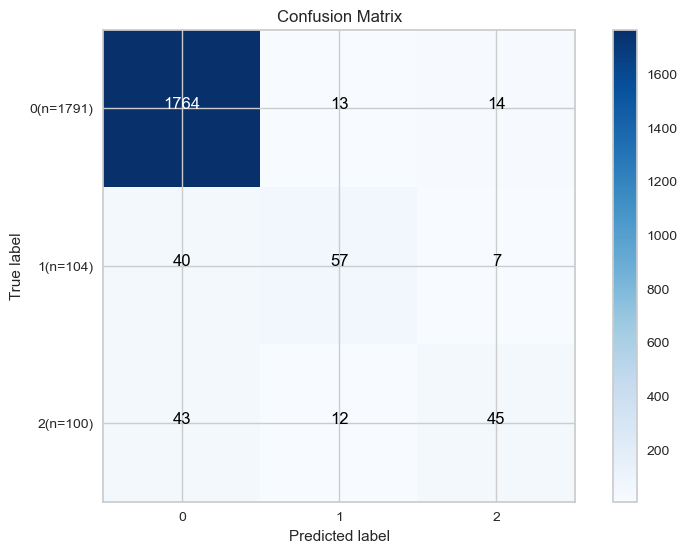

In [68]:
plot_confusion_matrix(con_mat, labels)

In [69]:
# (4) Accuracy
accuracy = accuracy_score(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Accuracy
args.accuracy_logs[classifier_name] = accuracy
args.accuracy_all_logs[args.y_default][classifier_name] = accuracy
accuracy

0.9353383458646617

In [70]:
# (5) Classification Report
print(classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)) # Precision, Recall, F1 score 지표 정리
args.classification_report_logs[classifier_name] = classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1791
           1       0.70      0.55      0.61       104
           2       0.68      0.45      0.54       100

    accuracy                           0.94      1995
   macro avg       0.78      0.66      0.71      1995
weighted avg       0.93      0.94      0.93      1995



C:\Users\Bang\Anaconda\envs\BangEnv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Bang\Anaconda\envs\BangEnv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

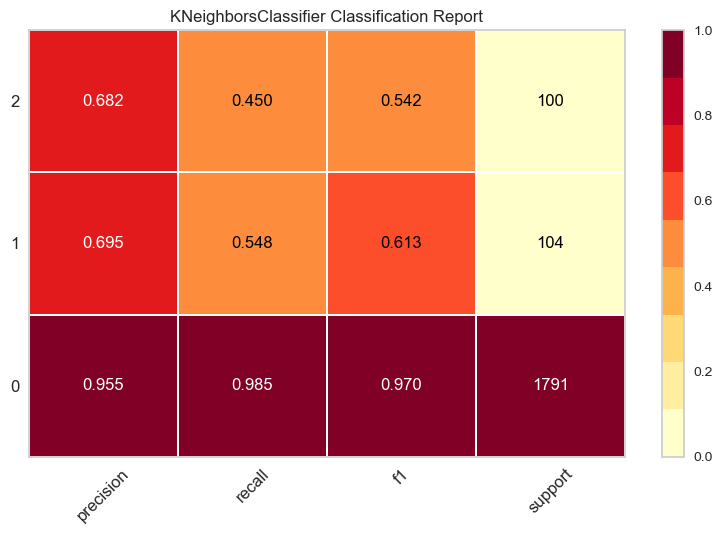

<AxesSubplot: title={'center': 'KNeighborsClassifier Classification Report'}>

In [71]:
visualizer = ClassificationReport(classifier, classes=labels, support=True)

visualizer.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))        # Fit the visualizer and the model
visualizer.score(X_test_scaled_df, eval(f"y_{args.y_default}_test_df"))        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### (3) Basic + GridSearch

In [72]:
# # (1) Train / (2) Predict
# args.accuracy_log = []
# for k in args.knn_neighbors_list:
#     classifier = KNeighborsClassifier(n_neighbors = k)
#     classifier.fit(X_train_df, eval(f"y_{args.y_default}_train_df"))
#     args.accuracy_log.append(classifier.score(X_test_df, eval(f"y_{args.y_default}_test_df")))

In [73]:
# # (3) Visualization / 4) Accuracy
# plt.plot(args.knn_neighbors_list, args.accuracy_log)
# plt.xlabel("k")
# plt.ylabel("Test Accuracy")
# plt.title("KNN Classifier Accuracy")
# plt.show()

### 2) Decision Tree

In [74]:
classifier_name = "DTC"
args.classifier_default = args.classifier[classifier_name]
print(args.classifier_default)

DecisionTreeClassifier(random_state=32)


In [75]:
# (1) Train
classifier = args.classifier_default
classifier.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))

if not os.path.exists(args.saved_model_path + f"{classifier_name}"):
    os.mkdir(args.saved_model_path + f"{classifier_name}")
    
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='wb') as f:
    pickle.dump(classifier, f)

In [76]:
# (2) Predict
with open(file=args.saved_model_path + f"scaler.pickle", mode='rb') as f:
    scaler = pickle.load(f)
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='rb') as f:
    classifier = pickle.load(f)
    
X_test_scaled_df = scaler.transform(X_test_df)
y_pred_df = classifier.predict(X_test_scaled_df)

In [77]:
# (3) Visualization
con_mat = confusion_matrix(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Confusion Matrix
args.con_mat_logs[classifier_name] = con_mat.tolist()
con_mat

array([[1715,   46,   30],
       [  38,   53,   13],
       [  37,   18,   45]], dtype=int64)

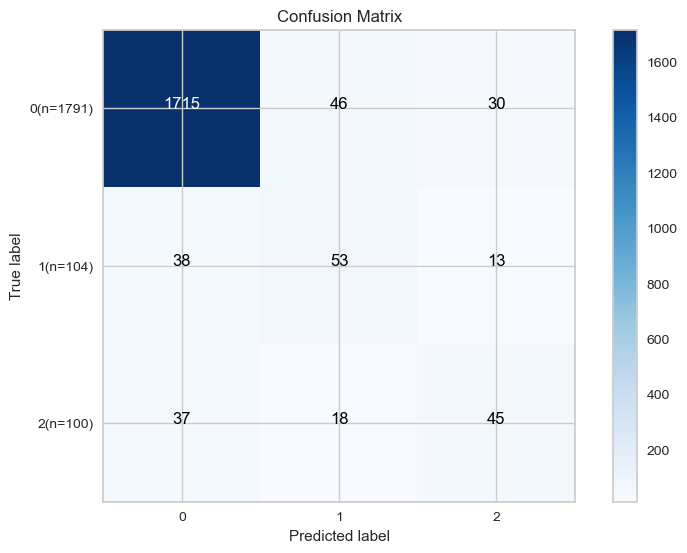

In [78]:
plot_confusion_matrix(con_mat, labels)

In [79]:
# (4) Accuracy
accuracy = accuracy_score(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Accuracy
args.accuracy_logs[classifier_name] = accuracy
args.accuracy_all_logs[args.y_default][classifier_name] = accuracy
accuracy

0.9087719298245615

In [80]:
# (5) Classification Report
print(classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)) # Precision, Recall, F1 score 지표 정리
args.classification_report_logs[classifier_name] = classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1791
           1       0.45      0.51      0.48       104
           2       0.51      0.45      0.48       100

    accuracy                           0.91      1995
   macro avg       0.64      0.64      0.64      1995
weighted avg       0.91      0.91      0.91      1995



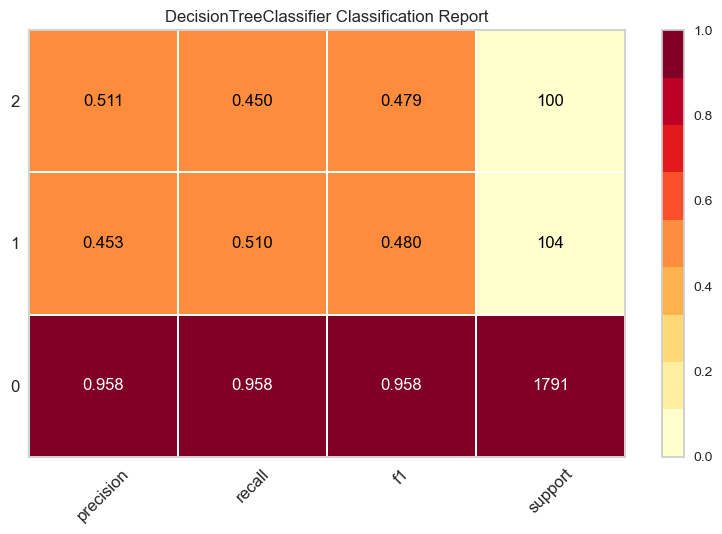

<AxesSubplot: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [81]:
visualizer = ClassificationReport(classifier, classes=labels, support=True)

visualizer.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))        # Fit the visualizer and the model
visualizer.score(X_test_scaled_df, eval(f"y_{args.y_default}_test_df"))        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

### 3) Random Forest

In [82]:
classifier_name = "RFC"
args.classifier_default = args.classifier[classifier_name]
print(args.classifier_default)

RandomForestClassifier(random_state=32)


In [83]:
# (1) Train
classifier = args.classifier_default
classifier.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))

if not os.path.exists(args.saved_model_path + f"{classifier_name}"):
    os.mkdir(args.saved_model_path + f"{classifier_name}")
    
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='wb') as f:
    pickle.dump(classifier, f)

C:\Users\Bang\AppData\Local\Temp\ipykernel_27632\2533119659.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))


In [84]:
# (2) Predict
with open(file=args.saved_model_path + f"scaler.pickle", mode='rb') as f:
    scaler = pickle.load(f)
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='rb') as f:
    classifier = pickle.load(f)
    
X_test_scaled_df = scaler.transform(X_test_df)
y_pred_df = classifier.predict(X_test_scaled_df)

In [85]:
# (3) Visualization
con_mat = confusion_matrix(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Confusion Matrix
args.con_mat_logs[classifier_name] = con_mat.tolist()
con_mat

array([[1768,   11,   12],
       [  45,   50,    9],
       [  37,   13,   50]], dtype=int64)

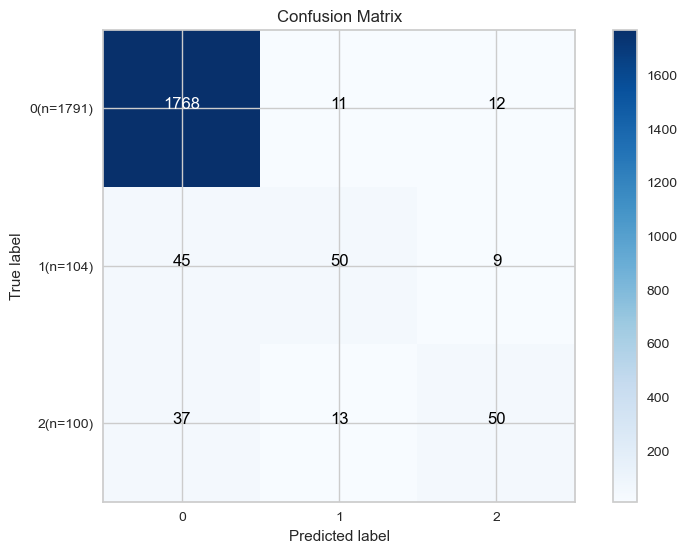

In [86]:
plot_confusion_matrix(con_mat, labels)

In [87]:
# (4) Accuracy
accuracy = accuracy_score(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Accuracy
args.accuracy_logs[classifier_name] = accuracy
args.accuracy_all_logs[args.y_default][classifier_name] = accuracy
accuracy

0.9363408521303258

In [88]:
# (5) Classification Report
print(classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)) # Precision, Recall, F1 score 지표 정리
args.classification_report_logs[classifier_name] = classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1791
           1       0.68      0.48      0.56       104
           2       0.70      0.50      0.58       100

    accuracy                           0.94      1995
   macro avg       0.78      0.66      0.71      1995
weighted avg       0.93      0.94      0.93      1995



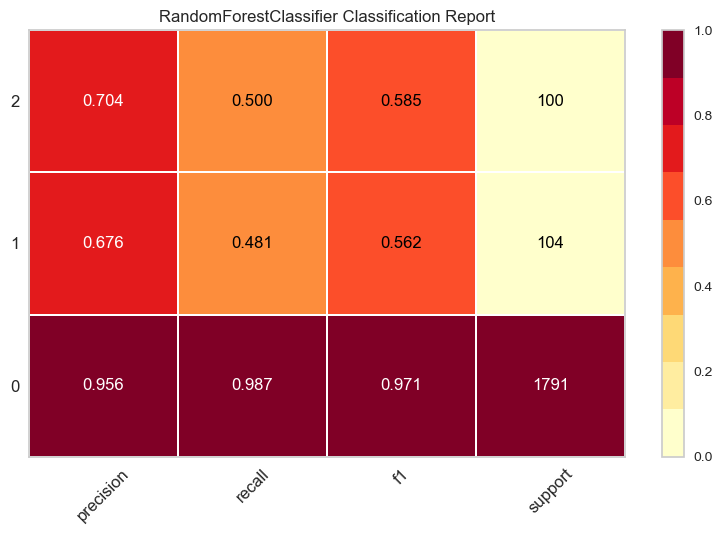

<AxesSubplot: title={'center': 'RandomForestClassifier Classification Report'}>

In [89]:
visualizer = ClassificationReport(classifier, classes=labels, support=True)

visualizer.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))        # Fit the visualizer and the model
visualizer.score(X_test_scaled_df, eval(f"y_{args.y_default}_test_df"))        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [90]:
# (6) Feature Importance
feature_scores = pd.Series(classifier.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

feature_scores

y10    0.090889
y11    0.053296
y8     0.047831
y5     0.043428
y12    0.041574
y4     0.039778
y13    0.037784
y7     0.033137
y14    0.029304
y6     0.027657
y15    0.027516
y3     0.026085
x16    0.025889
y16    0.025811
x10    0.025265
y9     0.025112
y1     0.024968
y17    0.024916
y2     0.024296
x15    0.024221
x13    0.023445
x14    0.023119
x8     0.022757
x11    0.022682
x5     0.022551
x9     0.022494
x17    0.022348
x7     0.022208
x12    0.022185
x6     0.020806
x3     0.019479
x1     0.019226
x2     0.018996
x4     0.018944
dtype: float64

### 4) SVM

In [91]:
classifier_name = "SVC"
args.classifier_default = args.classifier[classifier_name]
print(args.classifier_default)

SVC()


In [92]:
# (1) Train
classifier = args.classifier_default
classifier.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))

if not os.path.exists(args.saved_model_path + f"{classifier_name}"):
    os.mkdir(args.saved_model_path + f"{classifier_name}")
    
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='wb') as f:
    pickle.dump(classifier, f)

C:\Users\Bang\Anaconda\envs\BangEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
# (2) Predict
with open(file=args.saved_model_path + f"scaler.pickle", mode='rb') as f:
    scaler = pickle.load(f)
with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df.pickle", mode='rb') as f:
    classifier = pickle.load(f)
    
X_test_scaled_df = scaler.transform(X_test_df)
y_pred_df = classifier.predict(X_test_scaled_df)

In [94]:
# (3) Visualization
con_mat = confusion_matrix(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Confusion Matrix
args.con_mat_logs[classifier_name] = con_mat.tolist()
con_mat

array([[1784,    7,    0],
       [  64,   37,    3],
       [  71,    5,   24]], dtype=int64)

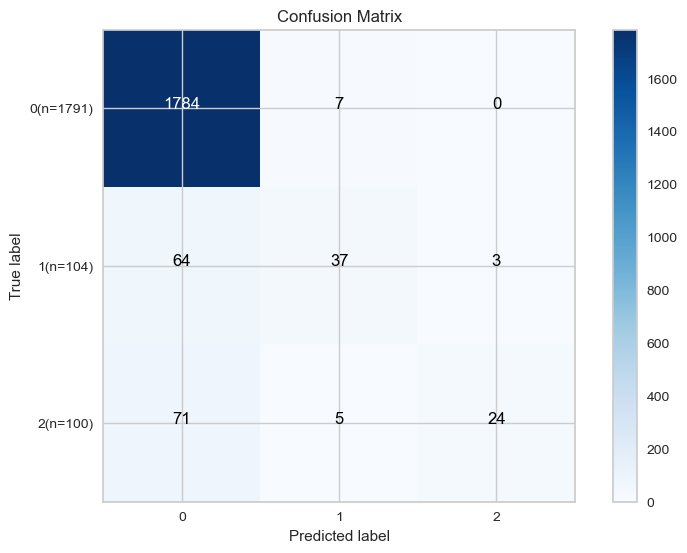

In [95]:
plot_confusion_matrix(con_mat, labels)

In [96]:
# (4) Accuracy
accuracy = accuracy_score(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Accuracy
args.accuracy_logs[classifier_name] = accuracy
args.accuracy_all_logs[args.y_default][classifier_name] = accuracy
accuracy

0.924812030075188

In [97]:
# (5) Classification Report
print(classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)) # Precision, Recall, F1 score 지표 정리
args.classification_report_logs[classifier_name] = classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1791
           1       0.76      0.36      0.48       104
           2       0.89      0.24      0.38       100

    accuracy                           0.92      1995
   macro avg       0.86      0.53      0.61      1995
weighted avg       0.92      0.92      0.91      1995



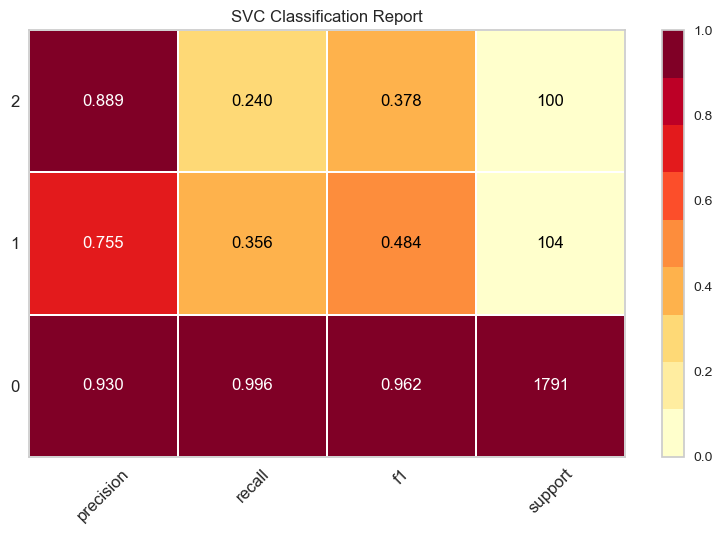

<AxesSubplot: title={'center': 'SVC Classification Report'}>

In [98]:
visualizer = ClassificationReport(classifier, classes=labels, support=True)

visualizer.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))        # Fit the visualizer and the model
visualizer.score(X_test_scaled_df, eval(f"y_{args.y_default}_test_df"))        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

### 6) Model Logs

#### (1) Visualization

In [99]:
args.accuracy_logs

{'KC': 0.9353383458646617,
 'DTC': 0.9087719298245615,
 'RFC': 0.9363408521303258,
 'SVC': 0.924812030075188}

In [100]:
args.con_mat_logs

{'KC': [[1764, 13, 14], [40, 57, 7], [43, 12, 45]],
 'DTC': [[1715, 46, 30], [38, 53, 13], [37, 18, 45]],
 'RFC': [[1768, 11, 12], [45, 50, 9], [37, 13, 50]],
 'SVC': [[1784, 7, 0], [64, 37, 3], [71, 5, 24]]}

In [101]:
args.classification_report_logs

{'KC': '              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97      1791\n           1       0.70      0.55      0.61       104\n           2       0.68      0.45      0.54       100\n\n    accuracy                           0.94      1995\n   macro avg       0.78      0.66      0.71      1995\nweighted avg       0.93      0.94      0.93      1995\n',
 'DTC': '              precision    recall  f1-score   support\n\n           0       0.96      0.96      0.96      1791\n           1       0.45      0.51      0.48       104\n           2       0.51      0.45      0.48       100\n\n    accuracy                           0.91      1995\n   macro avg       0.64      0.64      0.64      1995\nweighted avg       0.91      0.91      0.91      1995\n',
 'RFC': '              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.97      1791\n           1       0.68      0.48      0.56       104\n           2       0.70

### 5) RandomForest GridSearch

In [102]:
# classifier_name = "RFC"
# args.classifier_default = args.classifier[classifier_name]
# print(args.classifier_default)

In [103]:
# # (0) GridSearch Params
# param_grid = args.random_forest_gridsearch_params

In [104]:
# # (1) Train
# classifier = args.classifier_default
# grid_search = GridSearchCV(estimator=classifier,
#                            param_grid=param_grid,
#                            n_jobs=-1, 
#                            verbose=2
#                           )
# grid_search.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))

# if not os.path.exists(args.saved_model_path + f"{classifier_name}"):
#     os.mkdir(args.saved_model_path + f"{classifier_name}")
    
# with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df_gridsearch.pickle", mode='wb') as f:
#     pickle.dump(grid_search, f)

In [105]:
# # (2) Predict
# with open(file=args.saved_model_path + f"scaler.pickle", mode='rb') as f:
#     scaler = pickle.load(f)
# with open(file=args.saved_model_path + f"{classifier_name}\\y_{args.y_default}_train_df_gridsearch.pickle", mode='rb') as f:
#     grid_search = pickle.load(f)
    
# X_test_scaled_df = scaler.transform(X_test_df)
# y_pred_df = grid_search.predict(X_test_scaled_df)

In [106]:
# # (3) Visualization
# con_mat = confusion_matrix(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Confusion Matrix
# args.con_mat_logs[classifier_name] = con_mat.tolist()
# con_mat

In [107]:
# plot_confusion_matrix(con_mat, labels)

In [108]:
# # (4) Accuracy
# accuracy = accuracy_score(eval(f"y_{args.y_default}_test_df"), y_pred_df) # Accuracy
# args.accuracy_logs[classifier_name] = accuracy
# args.accuracy_all_logs[args.y_default][classifier_name] = accuracy
# accuracy

In [109]:
# # (5) Classification Report
# print(classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)) # Precision, Recall, F1 score 지표 정리
# args.classification_report_logs[classifier_name] = classification_report(eval(f"y_{args.y_default}_test_df"), y_pred_df)

In [110]:
# # classifier = args.classifier_default
# visualizer = ClassificationReport(grid_search, classes=labels, support=True)

# visualizer.fit(X_train_scaled_df, eval(f"y_{args.y_default}_train_df"))        # Fit the visualizer and the model
# visualizer.score(X_test_scaled_df, eval(f"y_{args.y_default}_test_df"))        # Evaluate the model on the test data
# visualizer.show()                       # Finalize and show the figure

In [111]:
# # (6) Feature Importance
# feature_scores = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)
# feature_scores = pd.DataFrame(feature_scores)
# feature_scores

In [112]:
# # (7) Best Params
# grid_search.best_params_

### 6) Model Logs

#### (1) Visualization

In [113]:
args.accuracy_logs

{'KC': 0.9353383458646617,
 'DTC': 0.9087719298245615,
 'RFC': 0.9363408521303258,
 'SVC': 0.924812030075188}

In [114]:
args.con_mat_logs

{'KC': [[1764, 13, 14], [40, 57, 7], [43, 12, 45]],
 'DTC': [[1715, 46, 30], [38, 53, 13], [37, 18, 45]],
 'RFC': [[1768, 11, 12], [45, 50, 9], [37, 13, 50]],
 'SVC': [[1784, 7, 0], [64, 37, 3], [71, 5, 24]]}

In [115]:
args.classification_report_logs

{'KC': '              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97      1791\n           1       0.70      0.55      0.61       104\n           2       0.68      0.45      0.54       100\n\n    accuracy                           0.94      1995\n   macro avg       0.78      0.66      0.71      1995\nweighted avg       0.93      0.94      0.93      1995\n',
 'DTC': '              precision    recall  f1-score   support\n\n           0       0.96      0.96      0.96      1791\n           1       0.45      0.51      0.48       104\n           2       0.51      0.45      0.48       100\n\n    accuracy                           0.91      1995\n   macro avg       0.64      0.64      0.64      1995\nweighted avg       0.91      0.91      0.91      1995\n',
 'RFC': '              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.97      1791\n           1       0.68      0.48      0.56       104\n           2       0.70

#### (2) Save Logs

1] 1개의 Y에 대한 accuracy log

In [116]:
if not os.path.exists(args.saved_model_path + f"{classifier_name}"):
    os.mkdir(args.saved_model_path + f"{classifier_name}")

args.json_data = {}
with open(file=args.saved_model_path + f"logs_y_{args.y_default}_train_df.json", mode='w', encoding='utf-8') as f:
    args.json_data["accuracy_logs"] = args.accuracy_logs
    args.json_data["con_mat_logs"] = args.con_mat_logs
    args.json_data["classification_report_logs"] = args.classification_report_logs
    json.dump(args.json_data, f, indent="\t")

2] 전체 Y에 대한 accuracy log

In [117]:
args.y_list.keys()

dict_keys(['neck', 'trunk', 'upperarm', 'lowerarm', 'legs', 'json_trunk_twist'])

In [118]:
args.accuracy_logs.keys()

dict_keys(['KC', 'DTC', 'RFC', 'SVC'])

In [119]:
if sorted(args.y_list.keys()) == sorted(args.accuracy_logs.keys()):
    print("hi")

### 6) Best Accuracy Model Save

#### (1) 1개의 Y에 대한 accuracy log

In [120]:
args.best_classifier_name = max(args.accuracy_logs, key=args.accuracy_logs.get)
args.best_classifier_name

'RFC'

In [121]:
with open(file=args.saved_model_path + f"best_{args.best_classifier_name}_y_{args.y_default}_train_df.pickle", mode='wb') as f:
    pickle.dump(classifier, f)